In [ ]:
'''
author:Jack Peng
data:2024.6.20
version:1.4
environment:matplotlib\numpy\time\scipy\sys\StingIO\contextmanager
'''
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy.stats import beta
import sys  
from io import StringIO  
from contextlib import contextmanager  
 
class K_machine():
    def __init__(self, K, count, Q, N=None, Beta=None):  # K为摇臂个数 count为选择列表 Q为平均奖赏列表 N为自定义概率列表
        self.K = K
        self.count = count
        self.Q = Q
        self.Beta = [[1, 1] for i in range(K)] # 每个摇臂有一个贝塔分布
        if N is None:
            np.random.seed(int(time.time()))
            self.N = [np.random.random() for _ in range(self.K)]
        else:
            self.N = N
            self.best_N = max(self.N)

    def Isgetreward(self, i):  # 判断是否获得i摇臂的奖励
        if np.random.random() < self.N[i]:
            return 1
        else:
            return 0

@contextmanager  
def suppress_stdout():  
    with StringIO() as f:  
        original_stdout = sys.stdout  
        sys.stdout = f  
        try:  
            yield  
        finally:  
            sys.stdout = original_stdout

def Greedy(machine, T):  # 贪心
    r1, r2 = 0, 0
    y1, y2 = [], []
    for i in range(1, T+1): # 总计T次
        if np.argmax(machine.Q) == 0: # 还没获得奖励时随机探索
            j = np.random.randint(0, machine.K) 
        else:
            j = np.argmax(machine.Q) # 每次选择machine.Q最大的
        reward = machine.Isgetreward(j) # 判断是否获得reward
        regret = max(machine.Q) - machine.Q[j] # 即时估计后悔machine.Q
        r1 += reward
        r2 += regret
        y1.append(r1 / i)
        y2.append(r2 / i)
        machine.Q[j] = (machine.Q[j] * machine.count[j] + reward) / (machine.count[j] + 1) # 更新machine.Q
        machine.count[j] += 1
    machine.Q = [round(i, 2) for i in machine.Q] # 保留两位小数
    machine.N = [round(i, 2) for i in machine.N]
    r2 = round(r2 ,2)
    print("Greedy:")
    print("累积奖励：", r1)
    print("累积后悔：", r2)
    print("摇臂选择次数：", [i if i > 0 else 0 for i in machine.count])
    print("摇臂估计概率：", [i if i > 0 else 0 for i in machine.Q])
    print("实际中奖概率：", [i if i > 0 else 0 for i in machine.N])
    print("\n")
    return [y1,y2]


def e_Greedy(machine, T, e):  # e贪心,动态e
    r1, r2 = 0, 0
    y1, y2 = [], []
    for i in range(1, T+1):
        if np.random.random() < e: # e / i动态改变e先探索后利用
            j = np.random.randint(0, machine.K) # 探索
        else:
            j = np.argmax(machine.Q) # 利用
        reward = machine.Isgetreward(j)
        regret = max(machine.Q) - machine.Q[j]
        r1 += reward
        r2 += regret
        y1.append(r1 / i)
        y2.append(r2 / i)
        machine.Q[j] = (machine.Q[j] * machine.count[j] + reward) / (machine.count[j] + 1) # 更新估计概率ListQ
        machine.count[j] += 1
    machine.Q = [round(i, 2) for i in machine.Q]
    machine.N = [round(i, 2) for i in machine.N]
    r2 = round(r2 ,2)
    print("ϵ-Greedy:ϵ-", e)
    print("累积奖励：", r1)
    print("累积后悔：", r2)
    print("摇臂选择次数：", [i if i > 0 else 0 for i in machine.count])
    print("摇臂估计概率：", [i if i > 0 else 0 for i in machine.Q])
    print("实际中奖概率：", [i if i > 0 else 0 for i in machine.N])
    print("\n")
    return [y1, y2]


def Softmax(machine, T, t):  # Softmax
    r1, r2 = 0, 0
    y1, y2 = [], []
    P_List = np.zeros(T) # 概率列表
    for i in range(1, T+1):
        total = sum(np.exp(machine.Q[j] / t) for j in range(machine.K)) # 计算分母
        for k in range(machine.K):  # 分配概率
            P_List[k] = np.exp(machine.Q[k] / t) / total
        choice = np.random.choice(len(P_List), p=P_List)  # 根据P_List进行区间选择
        reward = machine.Isgetreward(choice)
        regret = max(machine.N) - machine.N[choice]
        r1 += reward
        r2 += regret
        y1.append(r1 / i)
        y2.append(r2 / i)
        machine.Q[choice] = (machine.Q[choice] * machine.count[choice] + reward) / (machine.count[choice] + 1) # 更新Q值
        machine.count[choice] += 1
    machine.Q = [round(i, 2) for i in machine.Q]
    machine.N = [round(i, 2) for i in machine.N]
    r2 = round(r2 ,2)
    print("Softmax:t=", t)
    print("累积奖励：", r1)
    print("累积后悔：", r2)
    print("摇臂选择次数：", [i if i > 0 else 0 for i in machine.count])
    print("摇臂估计概率：", [i if i > 0 else 0 for i in machine.Q])
    print("实际中奖概率：", [i if i > 0 else 0 for i in machine.N])
    print("\n")
    return [y1, y2]

def UCB(machine, T, C):
    r1, r2 = 0, 0
    y1, y2 = [], []
    for i in range(1, T + 1):
        ucb_values = []
        for j in range(machine.K):
            if machine.count[j] == 0:
                ucb_values.append(np.inf)  # 对于未选择的拉杆，给一个无穷大的UCB值
            else:
                ucb_values.append(machine.Q[j] + C * np.sqrt(np.log(i) / machine.count[j]))  # UCB公式
        choice = np.argmax(ucb_values)  # 选出上置信界最大的拉杆
        reward = machine.Isgetreward(choice)
        regret = max(machine.Q) - machine.Q[choice]
        r1 += reward
        r2 += regret
        y1.append(r1 / i)
        y2.append(r2 / i)
        machine.Q[choice] = (machine.Q[choice] * machine.count[choice] + reward) / (machine.count[choice] + 1)
        machine.count[choice] += 1
    machine.Q = [round(i, 2) for i in machine.Q]
    machine.N = [round(i, 2) for i in machine.N]
    r2 = round(r2 ,2)
    print("UCB:C=", C)
    print("累积奖励：", r1)
    print("累积后悔：", r2)
    print("摇臂选择次数：", [i if i > 0 else 0 for i in machine.count])
    print("摇臂估计概率：", [i if i > 0 else 0 for i in machine.Q])
    print("实际中奖概率：", [i if i > 0 else 0 for i in machine.N])
    print("\n")
    return [y1, y2]

def Thompson(machine, T):
    r1, r2 = 0, 0
    y1, y2 = [], []
    for i in range(1, T + 1):
        samples = [beta.rvs(a, b) for a, b in machine.Beta] # 对每个摇臂进行采样
        choice = np.argmax(samples)
        machine.count[choice] += 1
        machine.Q[choice] = machine.Beta[choice][0] / (machine.Beta[choice][0] + machine.Beta[choice][1]) # 计算machine.Q = a/a+b
        reward = machine.Isgetreward(choice)
        regret = max(machine.Q) - machine.Q[choice]
        r1 += reward
        r2 += regret
        y1.append(r1 / i)
        y2.append(r2 / i)
        # 更新被选择摇臂的贝塔分布参数
        machine.Beta[choice] = (machine.Beta[choice][0] + reward, machine.Beta[choice][1] + 1 - reward)
    machine.Q = [round(i, 2) for i in machine.Q]
    machine.N = [round(i, 2) for i in machine.N]
    r2 = round(r2 ,2)
    print("Thompson:")
    print("累积奖励：", r1)
    print("累积后悔：", r2)
    print("摇臂选择次数：", [i if i > 0 else 0 for i in machine.count])
    print("摇臂估计概率：", [i if i > 0 else 0 for i in machine.Q])
    print("实际中奖概率：", [i if i > 0 else 0 for i in machine.N])
    print("\n")
    return [y1, y2]

In [106]:
K = 20 # 改变K的值
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=None, Beta=[1, 1])
N = machine.N
T = 3000 # 改变T的值
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Greedy:
累积奖励： 2572
累积后悔： 0.0
摇臂选择次数： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3000.0, 0]
摇臂估计概率： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.86, 0]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]




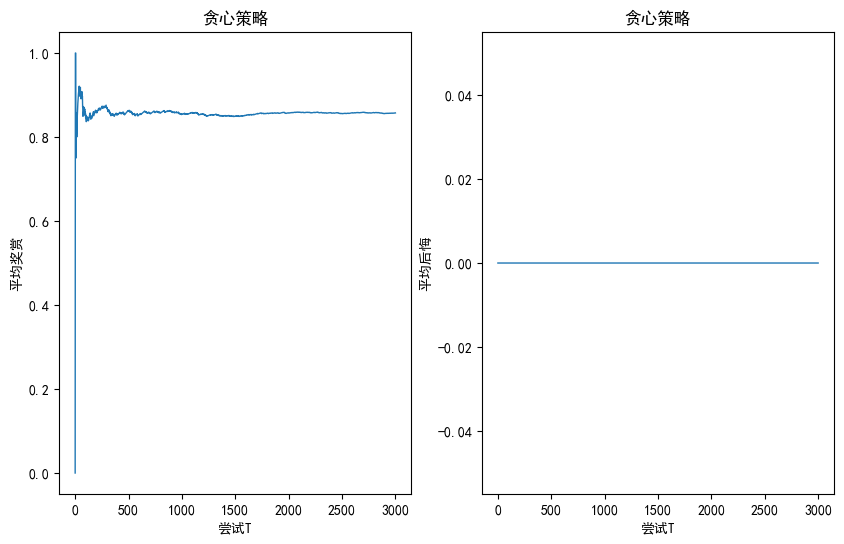

In [119]:
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N, Beta=[1, 1])
fig1, image = plt.subplots(1, 2, figsize=(10, 6))
y1, y2 = Greedy(machine, T)
x = list(range(T+1))
y1.insert(0, 0) 
y2.insert(0, 0) 
image[0].plot(x, y1, linewidth=1)
image[0].set_ylabel('平均奖赏')
image[0].set_xlabel('尝试T')
image[0].set_title('贪心策略') 
image[1].plot(x, y2, linewidth=1)
image[1].set_ylabel('平均后悔')
image[1].set_xlabel('尝试T')
image[1].set_title('贪心策略')  
plt.show()

e_Greedy:e= 0.7
累积奖励： 2036
累积后悔： 775.6
摇臂选择次数： [108.0, 126.0, 96.0, 112.0, 137.0, 119.0, 110.0, 122.0, 99.0, 101.0, 876.0, 101.0, 118.0, 103.0, 109.0, 102.0, 160.0, 97.0, 101.0, 103.0]
摇臂估计概率： [0.6, 0.53, 0.23, 0.31, 0.77, 0.12, 0.41, 0.72, 0.65, 0.45, 0.94, 0.3, 0.77, 0.5, 0.72, 0.61, 0.84, 0.54, 0.86, 0.71]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]




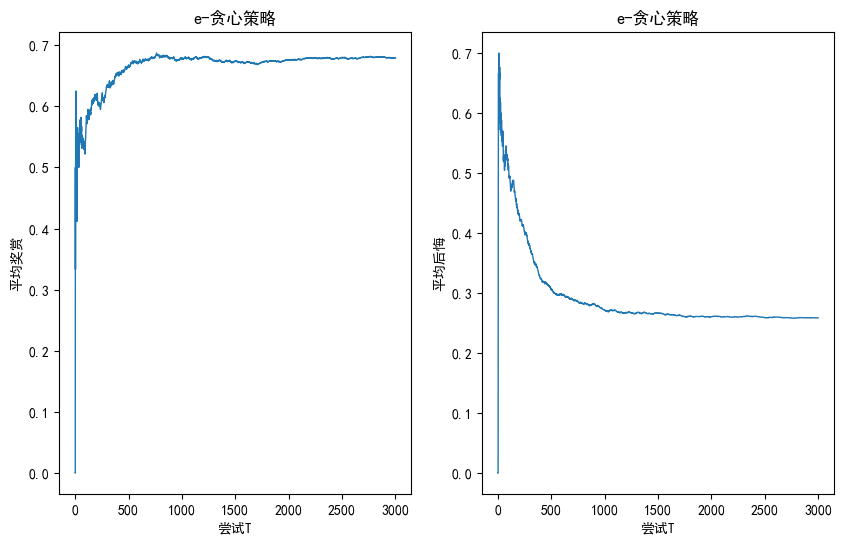

In [127]:
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N, Beta=[1, 1])
fig2, image = plt.subplots(1, 2, figsize=(10, 6))
y1, y2 = e_Greedy(machine, T, e=0.7)
x = list(range(T+1))
y1.insert(0, 0) 
y2.insert(0, 0) 
image[0].plot(x, y1, linewidth=1)
image[0].set_ylabel('平均奖赏')
image[0].set_xlabel('尝试T')
image[0].set_title('e-贪心策略') 
image[1].plot(x, y2, linewidth=1)
image[1].set_ylabel('平均后悔')
image[1].set_xlabel('尝试T')
image[1].set_title('e-贪心策略')  
plt.show()

Softmax:t= 0.7
累积奖励： 1899
累积后悔： 910.44
摇臂选择次数： [130.0, 140.0, 107.0, 102.0, 192.0, 80.0, 86.0, 169.0, 187.0, 139.0, 236.0, 70.0, 197.0, 168.0, 162.0, 163.0, 200.0, 143.0, 181.0, 148.0]
摇臂估计概率： [0.48, 0.52, 0.3, 0.33, 0.8, 0.12, 0.23, 0.67, 0.76, 0.43, 0.95, 0.24, 0.84, 0.58, 0.62, 0.58, 0.84, 0.52, 0.86, 0.69]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]




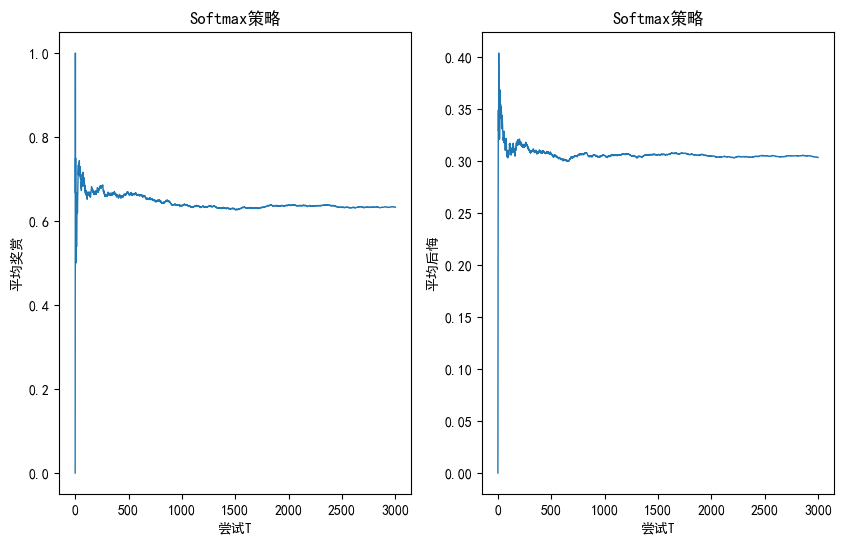

In [148]:
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N, Beta=[1, 1])
fig3, image = plt.subplots(1, 2, figsize=(10, 6))
y1, y2 = Softmax(machine, T, t=0.2) 
x = list(range(T+1))
y1.insert(0, 0) 
y2.insert(0, 0) 
image[0].plot(x, y1, linewidth=1)
image[0].set_ylabel('平均奖赏')
image[0].set_xlabel('尝试T')
image[0].set_title('Softmax策略') 
image[1].plot(x, y2, linewidth=1)
image[1].set_ylabel('平均后悔')
image[1].set_xlabel('尝试T')
image[1].set_title('Softmax策略')  
plt.show()

UCB:C= 0.1
累积奖励： 2797
累积后悔： 19.53
摇臂选择次数： [2.0, 1.0, 1.0, 2.0, 10.0, 1.0, 2.0, 3.0, 5.0, 5.0, 2935.0, 1.0, 3.0, 1.0, 1.0, 2.0, 9.0, 2.0, 4.0, 10.0]
摇臂估计概率： [0.5, 0, 0, 0.5, 0.8, 0, 0.5, 0.67, 0.8, 0.8, 0.94, 0, 0.67, 0, 0, 0.5, 0.78, 0.5, 0.75, 0.8]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]




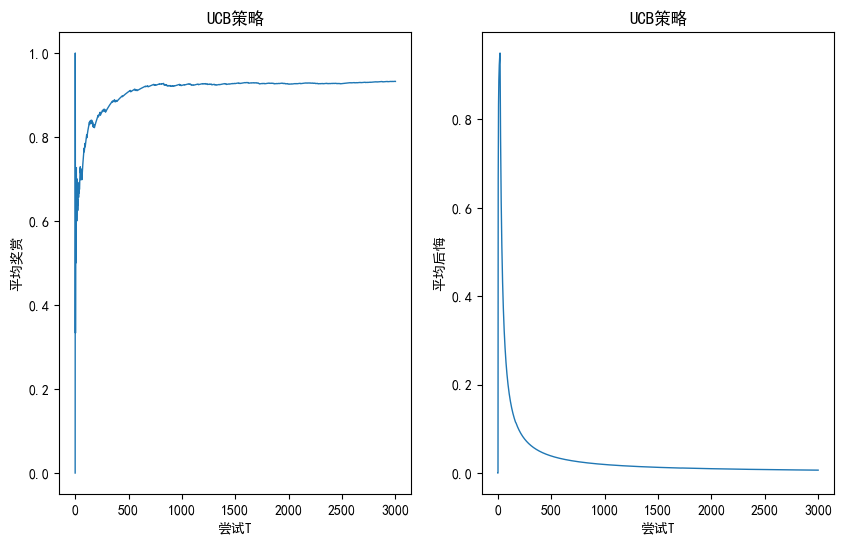

In [155]:
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N, Beta=[1, 1])
fig4, image = plt.subplots(1, 2, figsize=(10, 6))
y1, y2 = UCB(machine, T, C=0.1) # C小-利用；大-探索
x = list(range(T+1))
y1.insert(0, 0) 
y2.insert(0, 0) 
image[0].plot(x, y1, linewidth=1)
image[0].set_ylabel('平均奖赏')
image[0].set_xlabel('尝试T')
image[0].set_title('UCB策略') 
image[1].plot(x, y2, linewidth=1)
image[1].set_ylabel('平均后悔')
image[1].set_xlabel('尝试T')
image[1].set_title('UCB策略')  
plt.show()

Thompson:
累积奖励： 2732
累积后悔： 57.58
摇臂选择次数： [9.0, 4.0, 2.0, 3.0, 28.0, 3.0, 5.0, 11.0, 37.0, 4.0, 2649.0, 2.0, 27.0, 13.0, 18.0, 5.0, 99.0, 18.0, 46.0, 17.0]
摇臂估计概率： [0.6, 0.4, 0.33, 0.25, 0.72, 0.5, 0.5, 0.58, 0.79, 0.4, 0.93, 0.33, 0.82, 0.71, 0.68, 0.5, 0.86, 0.74, 0.81, 0.67]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]
[(6, 5), (2, 4), (1, 3), (1, 4), (21, 9), (2, 3), (3, 4), (7, 6), (31, 8), (2, 4), (2471, 180), (1, 3), (24, 5), (11, 4), (14, 6), (3, 4), (87, 14), (14, 6), (39, 9), (12, 7)]




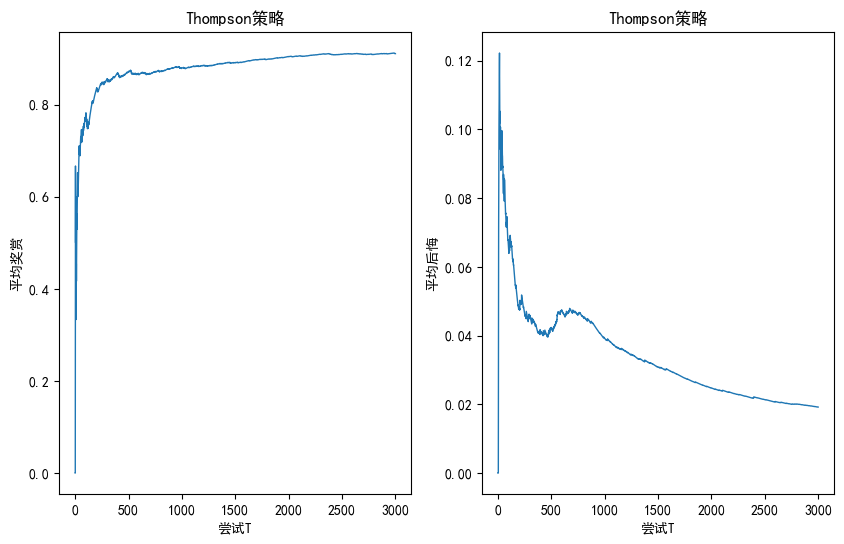

In [159]:
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N, Beta=[1, 1])
fig5, image = plt.subplots(1, 2, figsize=(10, 6))
y1, y2 = Thompson(machine, T)  
x = list(range(T+1))
y1.insert(0, 0) 
y2.insert(0, 0) 
image[0].plot(x, y1, linewidth=1)
image[0].set_ylabel('平均奖赏')
image[0].set_xlabel('尝试T')
image[0].set_title('Thompson策略') 
image[1].plot(x, y2, linewidth=1)
image[1].set_ylabel('平均后悔')
image[1].set_xlabel('尝试T')
image[1].set_title('Thompson策略')  
plt.show()

Greedy:
累积奖励： 2147
累积后悔： 0.0
摇臂选择次数： [0, 0, 0, 0, 0, 0, 0, 2999.0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0]
摇臂估计概率： [0, 0, 0, 0, 0, 0, 0, 0.72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]


e_Greedy:e= 0.2
累积奖励： 2574
累积后悔： 231.4
摇臂选择次数： [45.0, 34.0, 37.0, 26.0, 37.0, 37.0, 22.0, 33.0, 37.0, 37.0, 2361.0, 23.0, 33.0, 25.0, 28.0, 26.0, 34.0, 53.0, 45.0, 27.0]
摇臂估计概率： [0.42, 0.59, 0.27, 0.31, 0.76, 0.14, 0.41, 0.67, 0.7, 0.41, 0.94, 0.35, 0.7, 0.44, 0.64, 0.58, 0.88, 0.58, 0.87, 0.67]
实际中奖概率： [0.51, 0.53, 0.27, 0.31, 0.79, 0.09, 0.37, 0.71, 0.72, 0.38, 0.94, 0.28, 0.79, 0.55, 0.71, 0.55, 0.83, 0.57, 0.87, 0.69]


Softmax:t= 0.2
累积奖励： 2287
累积后悔： 485.61
摇臂选择次数： [56.0, 89.0, 14.0, 40.0, 241.0, 5.0, 7.0, 80.0, 251.0, 41.0, 624.0, 11.0, 214.0, 97.0, 193.0, 120.0, 329.0, 15.0, 530.0, 43.0]
摇臂估计概率： [0.5, 0.42, 0.14, 0.38, 0.78, 0, 0.29, 0.71, 0.72, 0.37, 0.94, 0.27, 0.77, 0.56, 0

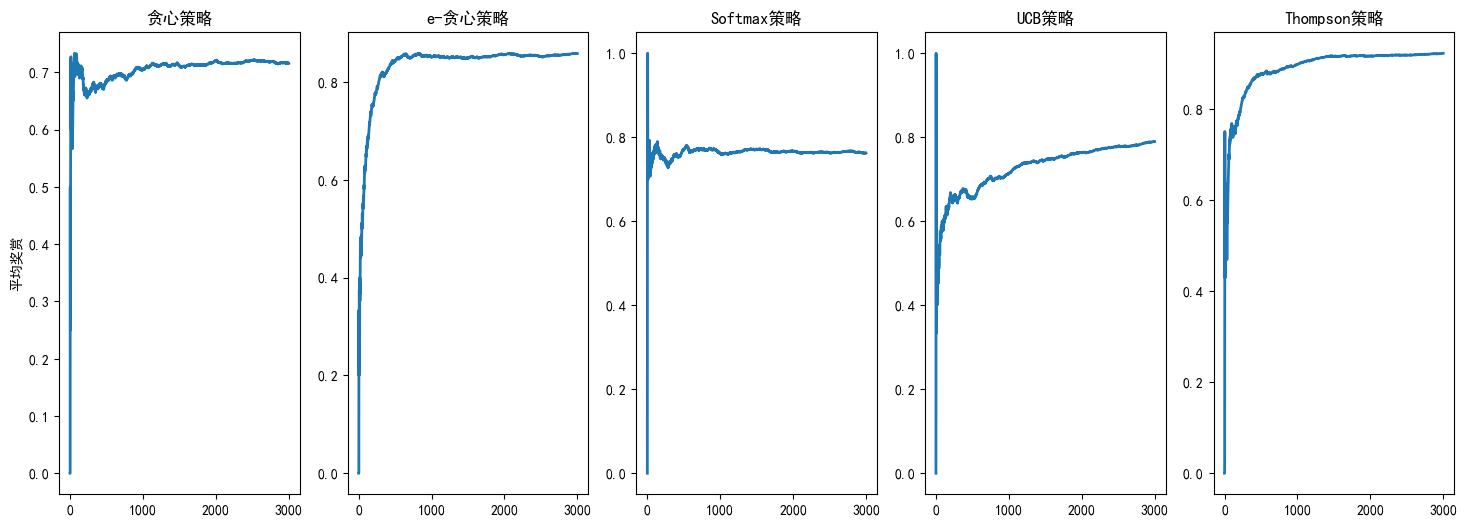

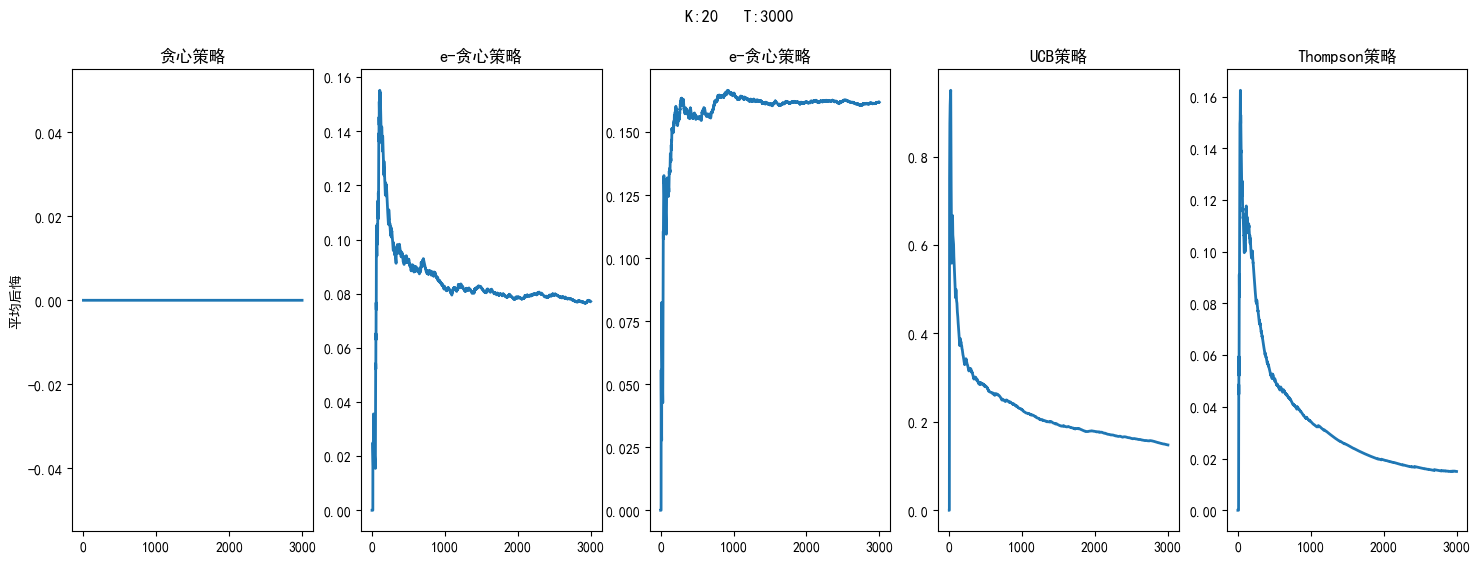

In [161]:
machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N, Beta=[1, 1])
fig6, image = plt.subplots(1, 5, figsize=(18, 6)) # 展示5张
fig7, image2 = plt.subplots(1, 5, figsize=(18, 6)) # 展示5张
y1, y5 = Greedy(machine, T)
x = [i for i in range(0, T+1)] # 3001个点
y1.insert(0, 0)
y5.insert(0, 0)
image[0].plot(x, y1, linewidth=2)
image[0].set_ylabel('平均奖赏')
image[0].set_title('贪心策略')
image2[0].plot(x, y5, linewidth=2)
image2[0].set_ylabel('平均后悔')
image2[0].set_title('贪心策略')


machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
y2, y6 = e_Greedy(machine, T, e=0.2)
x = [i for i in range(0, T+1)]
y2.insert(0, 0)
y6.insert(0, 0)
image[1].plot(x, y2, linewidth=2)
image[1].set_title('e-贪心策略')
image2[1].plot(x, y6, linewidth=2)
image2[1].set_title('e-贪心策略')

machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
y3, y7 = Softmax(machine, T, t=0.2)
x = [i for i in range(0, T+1)]
y3.insert(0, 0)
y7.insert(0, 0)
image[2].plot(x, y3, linewidth=2)
image[2].set_title('Softmax策略')
image2[2].plot(x, y7, linewidth=2)
image2[2].set_title('e-贪心策略')

machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
y4, y8 = UCB(machine, T, C=math.sqrt(2))
x = [i for i in range(0, T+1)]
y4.insert(0, 0)
y8.insert(0, 0)
image[3].plot(x, y4, linewidth=2)
image[3].set_title('UCB策略')
image2[3].plot(x, y8, linewidth=2)
image2[3].set_title('UCB策略')

machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
y5, y9 = Thompson(machine, T)
x = [i for i in range(0, T+1)]
y5.insert(0, 0)
y9.insert(0, 0)
image[4].plot(x, y5, linewidth=2)
image[4].set_title('Thompson策略')
image2[4].plot(x, y9, linewidth=2)
image2[4].set_title('Thompson策略')
plt.suptitle("K:%d   T:%d  " % (K, T))
plt.show()

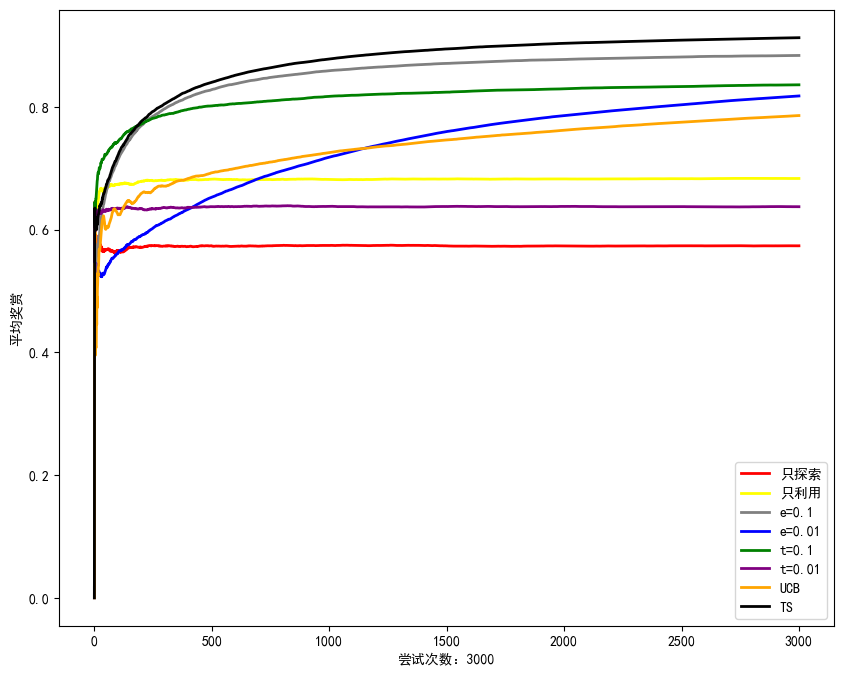

In [168]:
number = 100
x = [i for i in range(T+1)]
y1_avg = np.zeros(T + 1)  # 只探索  
y2_avg = np.zeros(T + 1)  # 只利用  
y3_avg = np.zeros(T + 1)  # e=0.1  
y4_avg = np.zeros(T + 1)  # e=0.01  
y5_avg = np.zeros(T + 1)  # t=0.1  
y6_avg = np.zeros(T + 1)  # t=0.01 
y7_avg = np.zeros(T + 1)  # UCB
y8_avg = np.zeros(T + 1)  # TS
with suppress_stdout():
    for i in range(number):
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y1 = e_Greedy(machine, T, e=1)[0] # 仅探索
        y1.insert(0, 0)
        y1_avg += y1
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y2 = Greedy(machine, T)[0] # 仅利用
        y2.insert(0, 0)
        y2_avg += y2
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y3 = e_Greedy(machine, T, e=0.1)[0] # e=0.1
        y3.insert(0, 0)
        y3_avg += y3
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y4 = e_Greedy(machine, T, e=0.01)[0] # e=0.01
        y4.insert(0, 0)
        y4_avg += y4
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y5 = Softmax(machine, T, t=0.1)[0] # t=0.1
        y5.insert(0, 0)
        y5_avg += y5
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y6 = Softmax(machine, T, t=0.01)[0] # t=0.01
        y6.insert(0, 0)
        y6_avg += y6
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y7 = UCB(machine, T, C=math.sqrt(2))[0] # UCB
        y7.insert(0, 0)
        y7_avg += y7
        machine = K_machine(K=K, count=np.zeros(K), Q=np.zeros(K), N=N)
        y8 = Thompson(machine, T)[0] # TS
        y8.insert(0, 0)
        y8_avg += y8
#print(y1_avg,y2_avg,y3_avg,y4_avg,y5_avg,y6_avg)
y1_avg /= number  
y2_avg /= number  
y3_avg /= number  
y4_avg /= number  
y5_avg /= number  
y6_avg /= number
y7_avg /= number
y8_avg /= number
# 创建一个新的图形
'''plt.figure(figsize=(10, 8))

plt.plot(x, y1_avg, label='只探索',linewidth=0.5,color='red')
plt.plot(x, y2_avg, label='只利用',linewidth=0.5,color='yellow')
plt.plot(x, y3_avg, label='e=0.1',linewidth=0.5,color='grey')
plt.plot(x, y4_avg, label='e=0.01',linewidth=0.5,color='blue')
plt.plot(x, y5_avg, label='t=0.1',linewidth=0.5,color='green')
plt.plot(x, y6_avg, label='t=0.01',linewidth=0.5,color='purple')

plt.legend() # 添加图例
plt.xlabel('尝试次数：%d' % T)
plt.ylabel('平均奖赏')

# 显示图形
plt.show()'''

# 创建一个新的图形
plt.figure(figsize=(10, 8))

plt.plot(x, y1_avg, label='只探索',linewidth=2,color='red')
plt.plot(x, y2_avg, label='只利用',linewidth=2,color='yellow')
plt.plot(x, y3_avg, label='e=0.1',linewidth=2,color='grey')
plt.plot(x, y4_avg, label='e=0.01',linewidth=2,color='blue')
plt.plot(x, y5_avg, label='t=0.1',linewidth=2,color='green')
plt.plot(x, y6_avg, label='t=0.01',linewidth=2,color='purple')
plt.plot(x, y7_avg, label='UCB',linewidth=2,color='orange')
plt.plot(x, y8_avg, label='TS',linewidth=2,color='#000000')

plt.legend() # 添加图例
plt.xlabel('尝试次数：%d' % T)
plt.ylabel('平均奖赏')

# 显示图形
plt.show()